In [171]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multitest
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

In [22]:
fpkm_df = pd.read_csv("all_annotated.csv", sep = ",")
fpkm_df

,t_name,gene_name,male_10,male_11,male_12,male_13,male_14A,male_14B,male_14C,male_14D,female_10,female_11,female_12,female_13,female_14A,female_14B,female_14C,female_14D
0,FBtr0114258,CR41571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,FBtr0346770,CG45784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,FBtr0302440,CR12798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,FBtr0302347,CR40182,23.712564,11.967821,20.767498,13.566818,18.802116,26.802691,22.819895,11.682728,21.894249,13.922059,16.482141,12.622680,31.800016,22.883186,14.330216,17.20257
4,FBtr0346769,CG45783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34713,FBtr0114187,CR40502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
34714,FBtr0304147,CR40719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
34715,FBtr0114216,CR40679,2.011199,0.000000,7.994137,2.064200,3.141665,0.000000,1.519102,9.190801,13.475658,1.771435,4.649351,7.004174,6.904506,0.835856,1.151747,1.98591
34716,FBtr0114222,CR40743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [27]:
#get the subset of the sample where the median is greater than 0
great_median_df = fpkm_df[(fpkm_df.median(axis = 1, numeric_only = True)) > 0]
great_median_df

,t_name,gene_name,male_10,male_11,male_12,male_13,male_14A,male_14B,male_14C,male_14D,female_10,female_11,female_12,female_13,female_14A,female_14B,female_14C,female_14D
3,FBtr0302347,CR40182,23.712564,11.967821,20.767498,13.566818,18.802116,26.802691,22.819895,11.682728,21.894249,13.922059,16.482141,12.622680,31.800016,22.883186,14.330216,17.202570
8,FBtr0113885,Parp,10.997173,0.000000,0.000000,0.000000,14.805335,0.000000,17.601667,10.729349,0.000000,0.000000,14.888651,14.518989,20.343670,4.087385,0.000000,25.284622
9,FBtr0301810,Alg-2,19.067924,0.000000,14.832370,27.793905,22.290230,7.846396,13.839143,12.905621,18.570707,2.919183,18.402807,26.431841,27.464781,7.432775,7.349162,22.792486
10,FBtr0113895,Tim17b,6.315716,3.935390,6.244336,69.942917,67.208557,7.605970,74.979057,53.740307,44.747662,16.834093,52.928318,77.950165,80.805580,31.863932,49.121342,77.608521
11,FBtr0345179,Tim17b,119.325905,11.631035,120.137291,75.778061,72.815582,123.849213,81.234352,59.657963,48.480839,18.238514,57.343983,86.686310,87.546967,34.522255,53.219402,84.936600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34663,FBtr0100884,mt:Cyt-b,33.341347,1.056151,9.832860,414.872559,102.529091,25.448748,71.750275,123.175087,119.770973,0.672975,48.309597,71.916695,237.404190,43.700970,75.445251,167.244049
34665,FBtr0100886,mt:ND1,25.209366,0.638430,21.281239,517.077271,326.313934,54.783924,360.265900,222.375244,306.410706,2.153615,200.718567,392.145020,433.656708,21.621773,91.902115,681.475891
34667,FBtr0100888,mt:lrRNA,2339.313232,34.080185,927.591858,4944.716797,2251.114990,593.744141,2493.088379,1651.994141,2578.825439,76.555481,2175.402344,3736.670654,122.910004,451.278412,692.211304,4556.642090
34684,FBtr0114261,CR41590,0.072563,0.000000,0.096390,0.102807,0.000000,0.000000,0.000000,0.126345,0.902268,0.000000,0.000000,0.162814,0.165381,0.000000,0.000000,0.052507


In [115]:
#apply a log2(FPKM + 0.1) data transformation to the dataframe
column_list = great_median_df.columns.values.tolist()
non_numeric_df = great_median_df[column_list[0:2]]
numeric_df = great_median_df[column_list[2:]]
transformed_df = numeric_df.add(0.1)
transformed_df = np.log2(transformed_df)
transformed_df = pd.concat([non_numeric_df, transformed_df], axis = 1, sort = False)
transformed_df

,t_name,gene_name,male_10,male_11,male_12,male_13,male_14A,male_14B,male_14C,male_14D,female_10,female_11,female_12,female_13,female_14A,female_14B,female_14C,female_14D
3,FBtr0302347,CR40182,4.573651,3.593093,4.383186,3.772605,4.240476,4.749679,4.518529,3.558602,4.459054,3.809626,4.051558,3.669331,4.995485,4.522507,3.851021,4.112914
8,FBtr0113885,Parp,3.472120,-3.321928,-3.321928,-3.321928,3.897757,-3.321928,4.145813,3.436875,-3.321928,-3.321928,3.905799,3.869772,4.353582,2.066050,-3.321928,4.665883
9,FBtr0301810,Alg-2,4.260622,-3.321928,3.900371,4.801878,4.484797,2.990301,3.801070,3.701063,4.222705,1.594158,4.209672,4.729653,4.784754,2.913181,2.897078,4.516802
10,FBtr0113895,Tim17b,2.681610,2.012708,2.665469,6.130167,6.072718,2.945977,6.230339,5.750615,5.486961,4.081859,5.728691,6.286330,6.338167,4.998373,5.621212,6.280001
11,FBtr0345179,Tim17b,6.899972,3.552258,6.909741,6.245611,6.188155,6.953605,6.345793,5.901059,5.602316,4.196805,5.844084,6.439396,6.453632,5.113628,5.736589,6.410012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34663,FBtr0100884,mt:Cyt-b,5.063561,0.209330,3.312209,8.696872,6.681296,4.675181,6.166922,6.945737,6.905339,-0.371506,5.597221,6.170259,7.891809,5.452891,6.239269,7.386673
34665,FBtr0100886,mt:ND1,4.661599,-0.437467,4.418274,9.014515,8.350559,5.778312,8.493319,7.797501,8.259794,1.172241,7.649749,8.615611,8.760742,4.441070,6.523595,9.412730
34667,FBtr0100888,mt:lrRNA,11.191931,5.095088,9.857502,12.271701,11.136488,9.213941,11.283776,10.690080,11.332554,6.260317,11.087133,11.867576,6.942632,8.818194,9.435277,12.153787
34684,FBtr0114261,CR41590,-2.534805,-3.321928,-2.348207,-2.301821,-3.321928,-3.321928,-3.321928,-2.143405,0.003268,-3.321928,-3.321928,-1.927886,-1.913863,-3.321928,-3.321928,-2.713053


In [116]:
#cluster using dendrogram
gene_names_df = transformed_df[column_list[1]]
transformed_num_df = transformed_df[column_list[2:]]
cluster_gene = linkage(transformed_num_df)
cluster_sample = linkage(transformed_num_df.T)

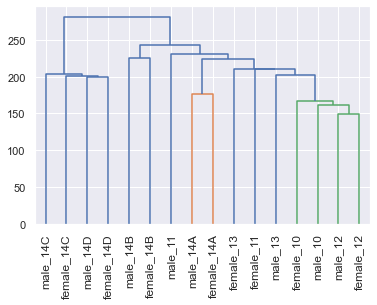

In [117]:
#plot the dendrogram for the sample
leaves = leaves_list(cluster_sample)
columns = column_list[2:]
plt.figure()
dendrogram(cluster_sample, labels = columns, leaf_rotation = 90)
plt.show()

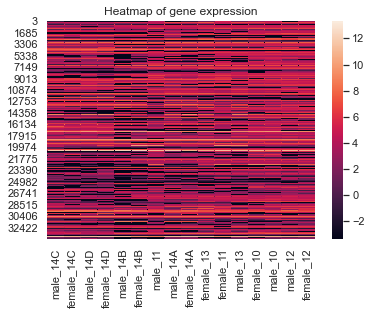

In [124]:
#plot the heatmap
sns.set()
leaf_list = list(leaves)
labels_list = []
for leaf in leaf_list:
    labels_list.append(columns[int(leaf)])
rearranged_df = transformed_num_df[labels_list]
ax = sns.heatmap(rearranged_df)
plt.title("Heatmap of gene expression")
plt.show()


In [137]:
#least squares regression for each gene
test = transformed_num_df.loc[3]
gene_index = gene_names_df.index.to_list()
transformed_num_df

,male_10,male_11,male_12,male_13,male_14A,male_14B,male_14C,male_14D,female_10,female_11,female_12,female_13,female_14A,female_14B,female_14C,female_14D
3,4.573651,3.593093,4.383186,3.772605,4.240476,4.749679,4.518529,3.558602,4.459054,3.809626,4.051558,3.669331,4.995485,4.522507,3.851021,4.112914
8,3.472120,-3.321928,-3.321928,-3.321928,3.897757,-3.321928,4.145813,3.436875,-3.321928,-3.321928,3.905799,3.869772,4.353582,2.066050,-3.321928,4.665883
9,4.260622,-3.321928,3.900371,4.801878,4.484797,2.990301,3.801070,3.701063,4.222705,1.594158,4.209672,4.729653,4.784754,2.913181,2.897078,4.516802
10,2.681610,2.012708,2.665469,6.130167,6.072718,2.945977,6.230339,5.750615,5.486961,4.081859,5.728691,6.286330,6.338167,4.998373,5.621212,6.280001
11,6.899972,3.552258,6.909741,6.245611,6.188155,6.953605,6.345793,5.901059,5.602316,4.196805,5.844084,6.439396,6.453632,5.113628,5.736589,6.410012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34663,5.063561,0.209330,3.312209,8.696872,6.681296,4.675181,6.166922,6.945737,6.905339,-0.371506,5.597221,6.170259,7.891809,5.452891,6.239269,7.386673
34665,4.661599,-0.437467,4.418274,9.014515,8.350559,5.778312,8.493319,7.797501,8.259794,1.172241,7.649749,8.615611,8.760742,4.441070,6.523595,9.412730
34667,11.191931,5.095088,9.857502,12.271701,11.136488,9.213941,11.283776,10.690080,11.332554,6.260317,11.087133,11.867576,6.942632,8.818194,9.435277,12.153787
34684,-2.534805,-3.321928,-2.348207,-2.301821,-3.321928,-3.321928,-3.321928,-2.143405,0.003268,-3.321928,-3.321928,-1.927886,-1.913863,-3.321928,-3.321928,-2.713053


In [159]:
#run all the genes through ols and get the p-value in a dictionary with gene name as key
def get_gene_exp(index):
    dic = {}
    gene_list = [10, 11, 12, 13, 14]
    x = []
    y = []
    for gene in gene_list:
        for column, values in transformed_num_df.loc[index].iteritems():
            if str(gene) in column:
                x.append(gene)
                y.append(values)
    dic["gene"] = x
    dic["value"] = y
    df = pd.DataFrame(dic)
    return(df)
gene_p_val_dic = {}
for index in gene_index:
    temp = get_gene_exp(index)
    results = smf.ols("value ~ gene", data = temp).fit()
    p_val = results.pvalues["gene"]
    gene_p_val_dic[gene_names_df.loc[index]] = p_val
gene_p_val_dic

{'CR40182': 0.7358926183273353,
 'Parp': 0.1623778416069654,
 'Alg-2': 0.2630800450456366,
 'Tim17b': 0.22144463001227782,
 'CG41128': 0.026844794625964875,
 'CG41099': 0.9449779686993134,
 'CG12581': 8.450609073393468e-05,
 'CG12582': 0.059896037402517935,
 'aux': 0.9795607227302627,
 'CG14641': 2.027652811935778e-06,
 'abs': 1.196869525350426e-06,
 'Vps24': 0.00037275166785971387,
 'CG9795': 0.5699473374035593,
 'CG9776': 0.015965380011706266,
 'Skp2': 0.1853707744930278,
 'CG1103': 0.5841333735689238,
 'hkb': 6.308140979502168e-10,
 'CG11739': 0.08119426532872144,
 'CG14646': 0.32035614607852614,
 'CG9855': 0.00010205231414105779,
 'CG9853': 0.07017151805655637,
 'CG14647': 0.002113000473720813,
 'lost': 8.12424212064905e-08,
 'srl': 8.151008884139017e-06,
 'eIF3-S10': 0.00013514272230503058,
 'CG1074': 0.1273719802748466,
 'CG9804': 0.15197124469832363,
 'CR44134': 0.3392143484403497,
 'CG14650': 0.3760980509892825,
 'CG31523': 0.76493803607282,
 'CG14651': 0.030811627101049288,
 '

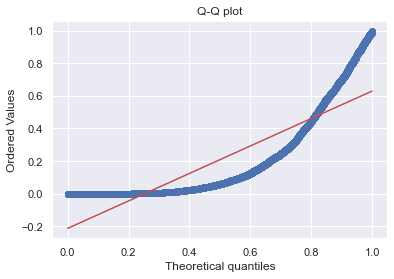

In [284]:
#plot the q-q plot
gene_p_val_df = pd.DataFrame.from_dict(gene_p_val_dic, orient = "index")
stats.probplot(gene_p_val_df[0], dist = "uniform", plot = plt)
plt.title("Q-Q plot")
plt.show()

In [285]:
#false discovery rate
fdr_correct = multitest.multipletests(gene_p_val_df[0], alpha = 0.1, method = "fdr_bh")[0]
gene_fdr_correct_df = gene_p_val_df[fdr_correct]
gene_fdr_list = gene_fdr_correct_df.index.to_list()
len(gene_fdr_list)

2632

In [274]:
#control for gender
def get_sex_exp(index):
    dic = {}
    gene_list = [10, 11, 12, 13, 14]
    x = []
    y = []
    gender = []
    for gene in gene_list:
        for column, values in transformed_num_df.loc[index].iteritems():
            if str(gene) in column:
                x.append(gene)
                y.append(values)
                if "female" in column:
                    gender.append("female")
                else:
                    gender.append("male")
    dic["gene"] = x
    dic["value"] = y
    dic["gender"] = gender
    df = pd.DataFrame(dic)
    return(df)
sex_p_val_dic = {}
for index in gene_index:
    temp = get_sex_exp(index)
    results = smf.ols("value ~ gene + gender", data = temp).fit()
    #p_val = results.pvalues["gender[T.male]"]
    p_val = results.pvalues["gene"]
    sex_p_val_dic[gene_names_df.loc[index]] = p_val
sex_p_val_dic


{'CR40182': 0.745478774482049,
 'Parp': 0.1749870671138617,
 'Alg-2': 0.27412334401282545,
 'Tim17b': 0.22735044963681247,
 'CG41128': 0.027935604251670312,
 'CG41099': 0.9466861020439795,
 'CG12581': 0.0001543306798663445,
 'CG12582': 0.07007357410570823,
 'aux': 0.9779782579460478,
 'CG14641': 4.08739135677661e-06,
 'abs': 2.899826121627587e-06,
 'Vps24': 0.0006110194929409228,
 'CG9795': 0.5647459329334839,
 'CG9776': 0.020376061043861738,
 'Skp2': 0.18922656810275257,
 'CG1103': 0.5948859272909188,
 'hkb': 2.5782776853439113e-09,
 'CG11739': 0.0932898688831614,
 'CG14646': 0.33890831395668863,
 'CG9855': 0.0001371510314755161,
 'CG9853': 0.05494314198916263,
 'CG14647': 0.0029078762307308105,
 'lost': 2.3696826081475218e-07,
 'srl': 1.6067267814243852e-05,
 'eIF3-S10': 0.00012779718131043219,
 'CG1074': 0.13847237874747317,
 'CG9804': 0.16790382176810706,
 'CR44134': 0.35772526057122156,
 'CG14650': 0.3928484295169822,
 'CG31523': 0.7675972991980596,
 'CG14651': 0.03759205672489231

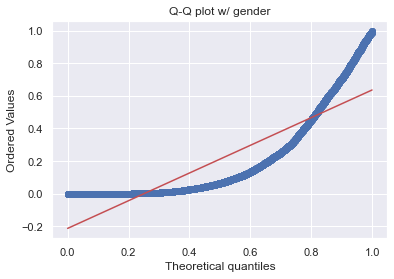

In [283]:
#q-q plot with sex as covariate
sex_p_val_df = pd.DataFrame.from_dict(sex_p_val_dic, orient = "index")
stats.probplot(sex_p_val_df[0], dist = "uniform", plot = plt)
plt.title("Q-Q plot w/ gender")
plt.show()

In [286]:
#false discovery rate with gender as covariate
gender_fdr_correct = multitest.multipletests(sex_p_val_df[0], alpha = 0.1, method = "fdr_bh")[0]
gender_fdr_correct_df = sex_p_val_df[gender_fdr_correct]
sex_fdr_list = gender_fdr_correct_df.index.to_list()
len(sex_fdr_list)

2536

In [298]:
#percentage overlap with and without sex as a covariate
overlap_list = list(set(genes_fdr_list) & set(sex_fdr_list))
per_overlap = (len(overlap_list)/len(gene_fdr_list))*100
print("The percent overlap is around " + str(per_overlap))

The percent overlap is around 81.0790273556231


In [289]:
from bioinfokit import analys, visuz

In [302]:
#control for gender and get the beta values
def get_sex_exp(index):
    dic = {}
    gene_list = [10, 11, 12, 13, 14]
    x = []
    y = []
    gender = []
    for gene in gene_list:
        for column, values in transformed_num_df.loc[index].iteritems():
            if str(gene) in column:
                x.append(gene)
                y.append(values)
                if "female" in column:
                    gender.append("female")
                else:
                    gender.append("male")
    dic["gene"] = x
    dic["value"] = y
    dic["gender"] = gender
    df = pd.DataFrame(dic)
    return(df)
beta_val_dic = {}
for index in gene_index:
    temp = get_sex_exp(index)
    results = smf.ols("value ~ gene + gender", data = temp).fit()
    #p_val = results.pvalues["gender[T.male]"]
    p_val = results.params["gene"]
    beta_val_dic[gene_names_df.loc[index]] = p_val
beta_val_dic
beta_val_df = pd.DataFrame.from_dict(beta_val_dic, orient = "index")
beta_val_df.columns = ["beta"]
beta_val_df

,beta
CR40182,0.026464
Parp,0.880440
Alg-2,0.388746
Tim17b,0.201195
CG41128,0.742588
...,...
mt:Cyt-b,0.820108
mt:ND1,0.942403
mt:lrRNA,0.231565
CR41590,-0.212609


In [303]:
#get a dataframe of both the p-values and the beta values
sex_p_val_df.columns = ["p_val"]
beta_p_val_df = pd.concat([sex_p_val_df, beta_val_df], axis = 1, sort = False)
beta_p_val_df

,p_val,beta
CR40182,0.745479,0.026464
Parp,0.174987,0.880440
Alg-2,0.274123,0.388746
Tim17b,0.227350,0.201195
CG41128,0.027936,0.742588
...,...,...
mt:Cyt-b,0.056993,0.820108
mt:ND1,0.057250,0.942403
mt:lrRNA,0.560402,0.231565
CR41590,0.177894,-0.212609


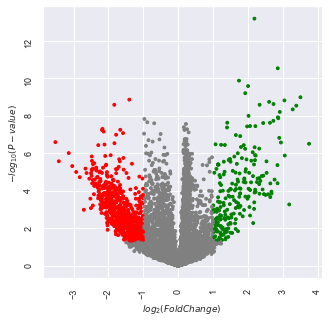

In [304]:
#draw the volcano plot
visuz.gene_exp.volcano(df = beta_p_val_df, lfc = "beta", pv = "p_val", show = True)